# Text to Text Transfer Transformer

A pure transformer based architecure

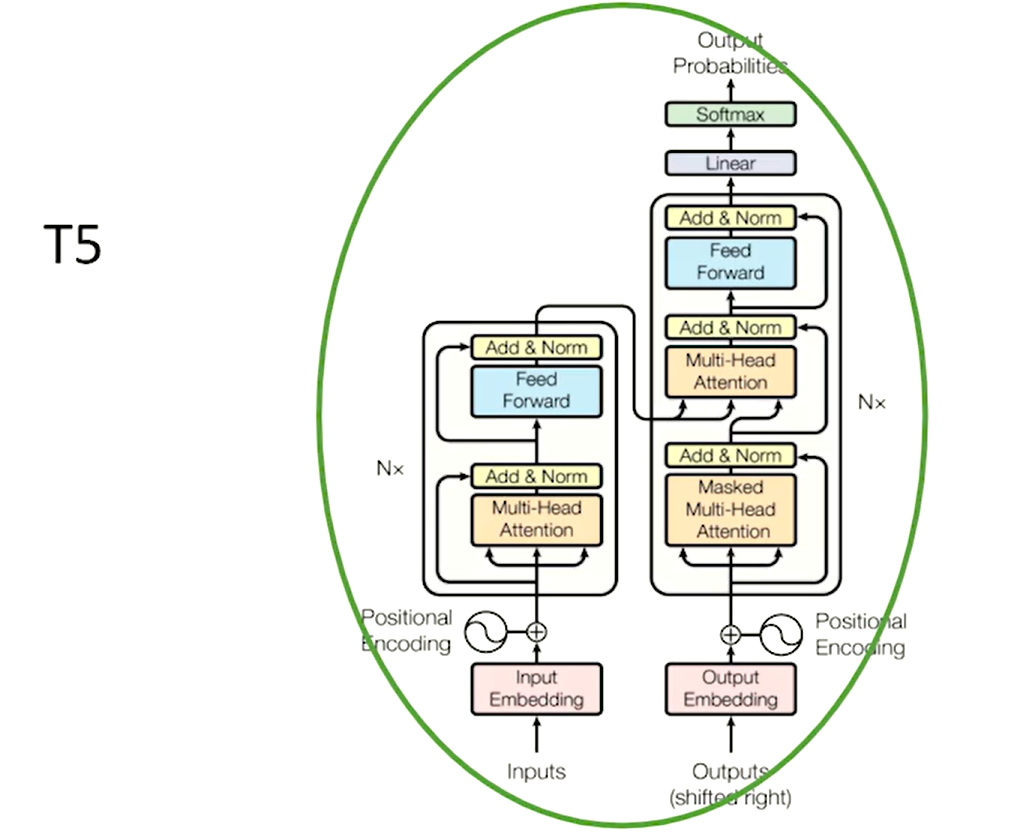

T5 was pretrained on Common Crawl Web with Three training objectives:

causal (auto-regressive) language modeling: predicting the next word
BERT-style objective: masking words and predicting the original text
Deshuffling: shuffling the input randomly and predicting the original text

Sentinel tokens are used like a masking task to predict missing chunks of text

    Original text : Thank you `for inviting` me to your party `last` week.

    Input text : Thank you <X> me to your party <Y> week.

    Target : <X> for inviting <Y> last <Z>
    
It was pretrined on both supervised and unsupervised tasks like translation, liguistic acceptability (CoLA: The Corpus of Linguistic Acceptability - checking for grammatical correctess), semantic text similarity (STSB - Semantic Text Similarity Benchmark -Are two sentences semantically similar), summarization

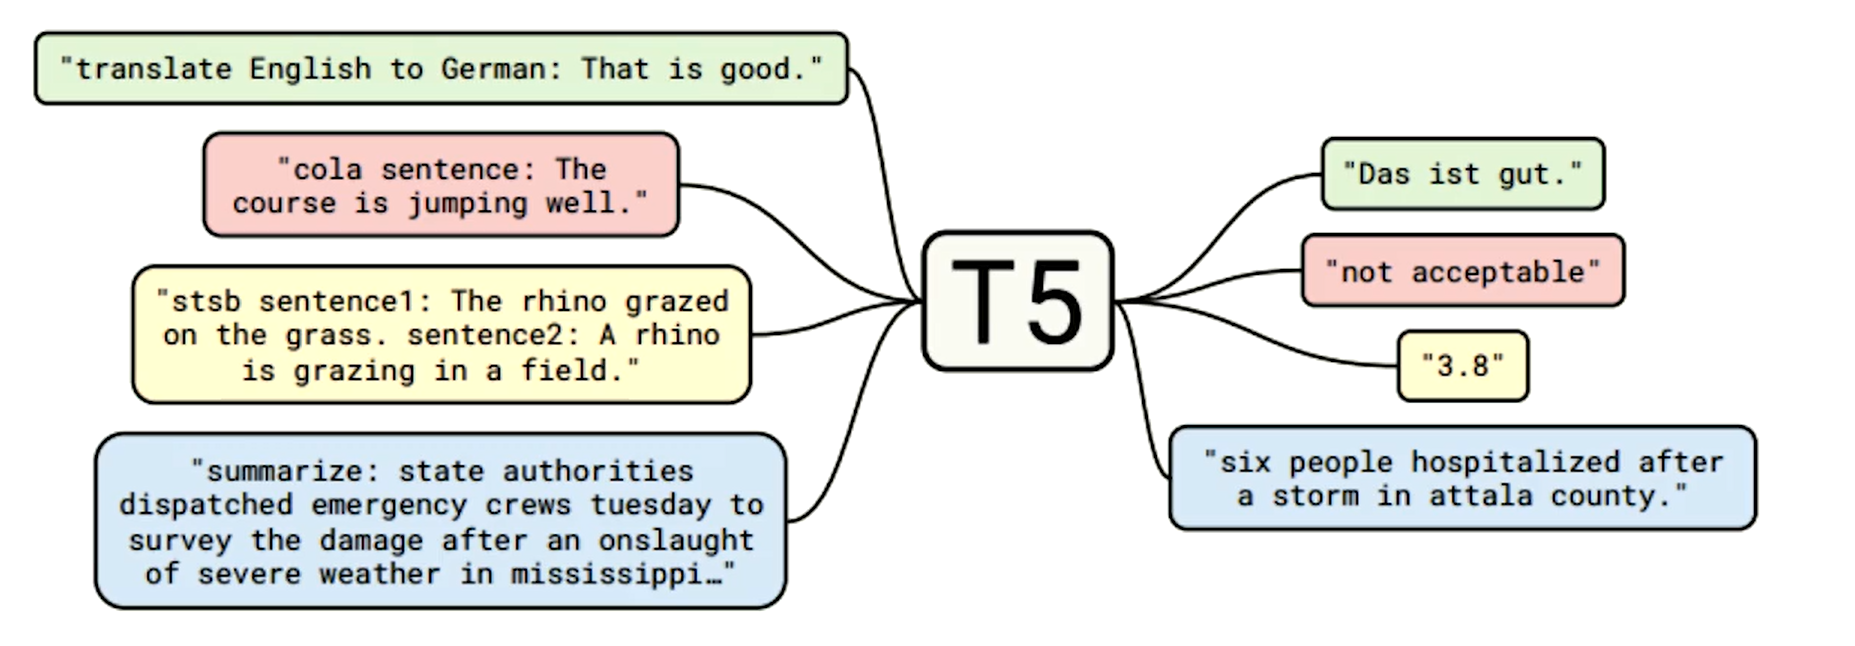


Cross Attention

The mechanism where the model attends to different parts of the input sequence (source) while generating the output sequence (target).This enables the model to consider the entire input context when generating each part of the output.

When passing information from `encoder` to `decoder`, Using keys and values from
the encoder and queries from the decoder. Keys and Value matrices come from the multi-headed attention in the encoder and Query matrices from the decoder. 

As T5 is decoding text, it has a "query" ie. a reason for speaking. It looks to the encoder to understand the original input as it relates to what is actively being decoded (the keys and values).

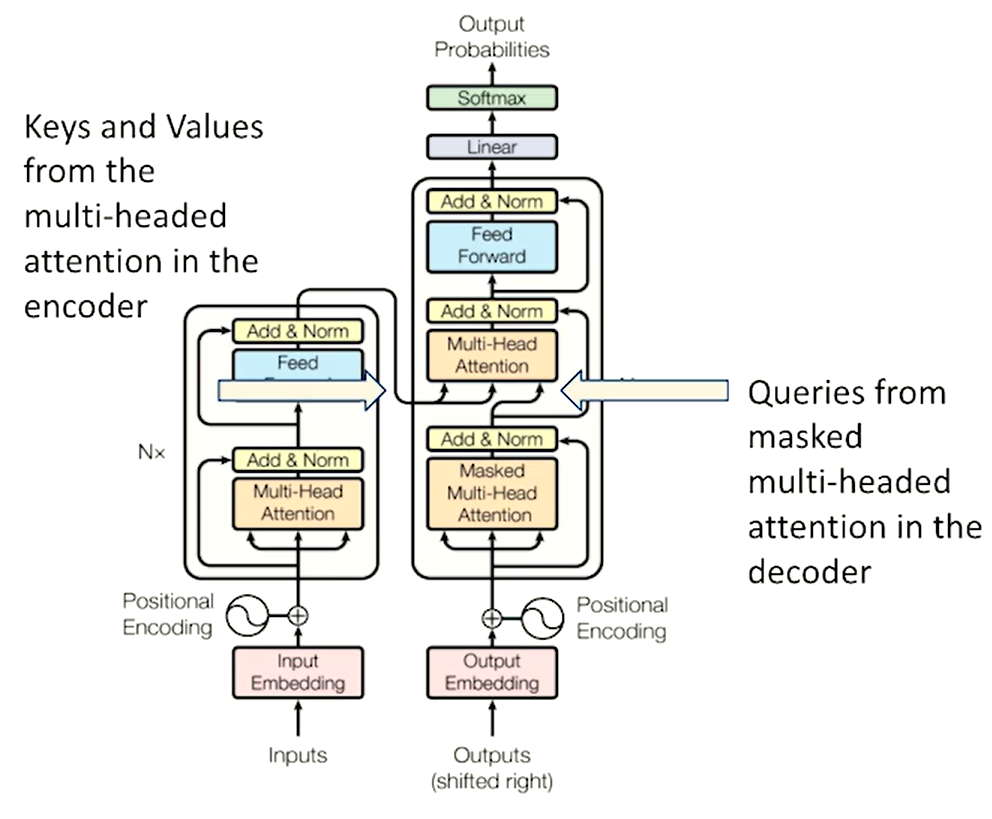

In [1]:
from transformers import T5ForConditionalGeneration, T5Tokenizer

In [2]:
base_model = T5ForConditionalGeneration.from_pretrained('t5-base')
base_tokenizer = T5Tokenizer.from_pretrained('t5-base')

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/models/t5/tokenization_t5.py:240: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the

In [3]:
base_model

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [4]:
text_to_summarize = """In T5 (Text-To-Text Transfer Transformer) and other transformer-based models, cross-attention refers to the mechanism where the model attends to different parts of the input sequence (source) while generating the output sequence (target). In the context of T5, which is designed for various text-to-text tasks, this mechanism is crucial for capturing relationships between input and output.
In a standard self-attention mechanism, each position in the sequence attends to all positions in the same sequence. Cross-attention, on the other hand, allows each position in the target sequence to attend to all positions in the source sequence. This enables the model to consider the entire input context when generating each part of the output."""

text_to_summarize = text_to_summarize.strip().replace("\n","")

t5_text = "summarize: " + text_to_summarize

input_ids = base_tokenizer.encode(t5_text,return_tensors='pt')

summary_ids = base_model.generate(input_ids,num_beams=4,no_repeat_ngram_size=3,min_length=30,max_length=50,early_stopping=True)

output = base_tokenizer.decode(summary_ids[0],skip_special_tokens=True)

output

'cross-attention refers to the mechanism where the model attends to different parts of the input sequence (source) while generating the output sequence (target) mechanism is crucial for capturing relationships between input and output.'

In [5]:
input_ids = base_tokenizer.encode('translate English to German: Deep Learning is Love',return_tensors='pt')

translate_ids =  base_model.generate(input_ids,num_beams=4,no_repeat_ngram_size=3,max_length=10,early_stopping=True)

output = base_tokenizer.decode(translate_ids[0],skip_special_tokens=True)

output

'Tiefes Lernen ist Liebe'

In [6]:
input_ids = base_tokenizer('translate English to German: Deep Learning is Love',return_tensors='pt').input_ids
labels = base_tokenizer('Tiefes Lernen ist Liebe',return_tensors='pt').input_ids

loss = base_model(input_ids=input_ids,labels=labels).loss
labels,loss

(tensor([[19393,    15,     7, 14572,    35,   229, 10484,     1]]),
 tensor(0.1395, grad_fn=<NllLossBackward0>))

In [7]:
from transformers import Trainer,TrainingArguments, DataCollatorForSeq2Seq, T5ForConditionalGeneration, pipeline

import pandas as pd
from datasets import Dataset

reviews = pd.read_csv('/kaggle/input/amazon-fine-food-reviews/Reviews.csv')[['Text', 'Summary', 'Score']]

# def add_punc(s):
#     if s[-1] not in (".","!","?"):
#         s = s + "."
reviews.dropna(inplace=True)

# reviews['Summary']  = reviews['Summary'].map(add_punc)

In [8]:
reviews = reviews[(reviews['Summary'].str.len() < 100) & (reviews['Summary'].str.len() >= 30)]

In [9]:
reviews.shape

(150292, 3)

In [10]:
reviews_dataset = Dataset.from_pandas(reviews.astype(str).sample(5000))

In [11]:
base_model = T5ForConditionalGeneration.from_pretrained('t5-small')
base_tokenizer = T5Tokenizer.from_pretrained('t5-small')

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [12]:
prefix = "summarize: "

def preprocessor(data):
    inputs = [prefix + doc for doc in data['Text']]
    model_inputs = base_tokenizer(inputs,max_length=1024,truncation=True)
    labels = base_tokenizer(data['Summary'],max_length=128,truncation=True)
    model_inputs['labels'] = labels['input_ids']
    
    return model_inputs

In [13]:
tokenized_review_dataset = reviews_dataset.map(preprocessor,batched=True)
tokenized_review_dataset = tokenized_review_dataset.train_test_split(test_size=0.1)

  0%|          | 0/5 [00:00<?, ?ba/s]

In [14]:
data_collator = DataCollatorForSeq2Seq(tokenizer=base_tokenizer,model=base_model)

In [15]:
training_args = TrainingArguments(
                output_dir="./t5_res",                
                num_train_epochs=20,
                per_device_train_batch_size=32,
                per_device_eval_batch_size=32,                
                logging_steps=50,
                load_best_model_at_end=True,
                evaluation_strategy='epoch',
                save_strategy='epoch'                    
                )

trainer = Trainer(
            model=base_model,
            args=training_args,
            data_collator=data_collator,
            train_dataset=tokenized_review_dataset['train'],
            eval_dataset=tokenized_review_dataset['test']
            )

trainer.evaluate()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


{'eval_loss': 4.969822406768799,
 'eval_runtime': 303.9495,
 'eval_samples_per_second': 1.645,
 'eval_steps_per_second': 0.053}

In [ ]:
trainer.train()